# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "VDNEW5"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train VDSR v5.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train VDSR v5.ipynb
/media/SSD/superres/Results/Superresolution train VDSR v5


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage,Normalize

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [11]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

(731, 491) (720, 480)


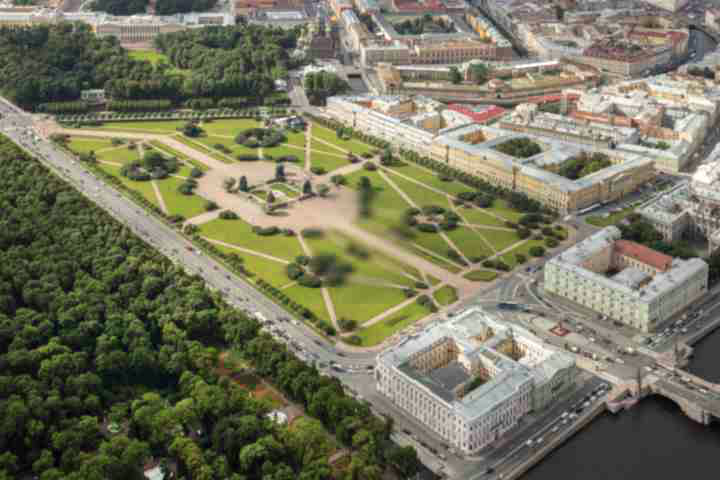

In [12]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [13]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
        #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [14]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,16)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [15]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [16]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(1,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [17]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

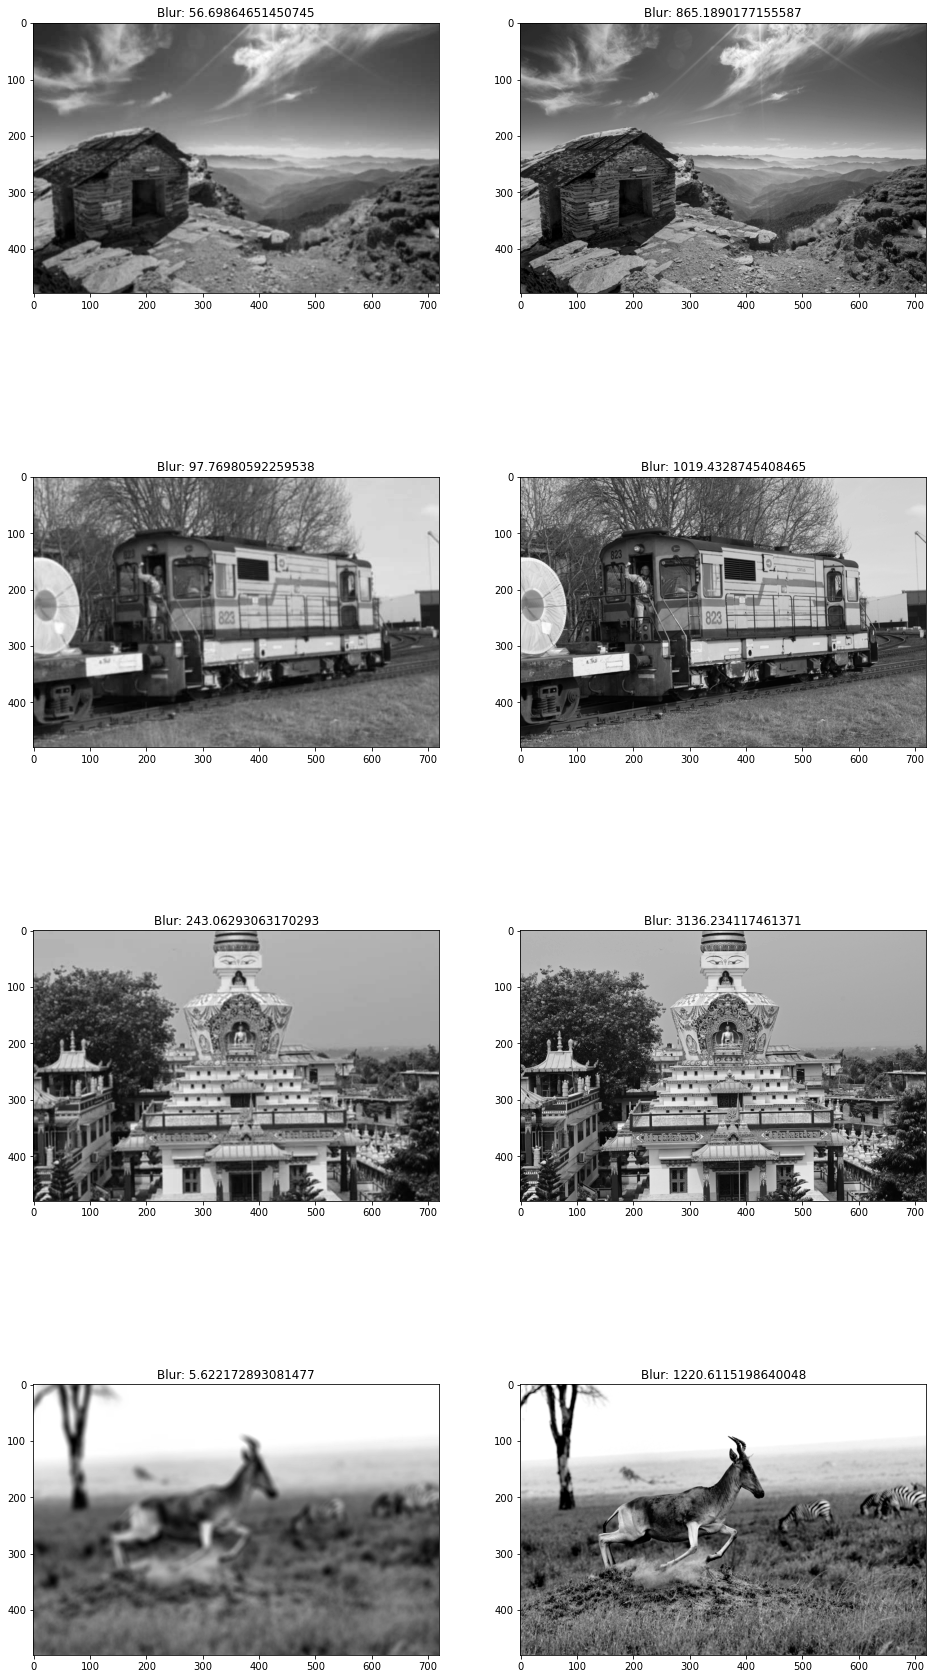

In [18]:
show_batch(training_data_loader,size =8)

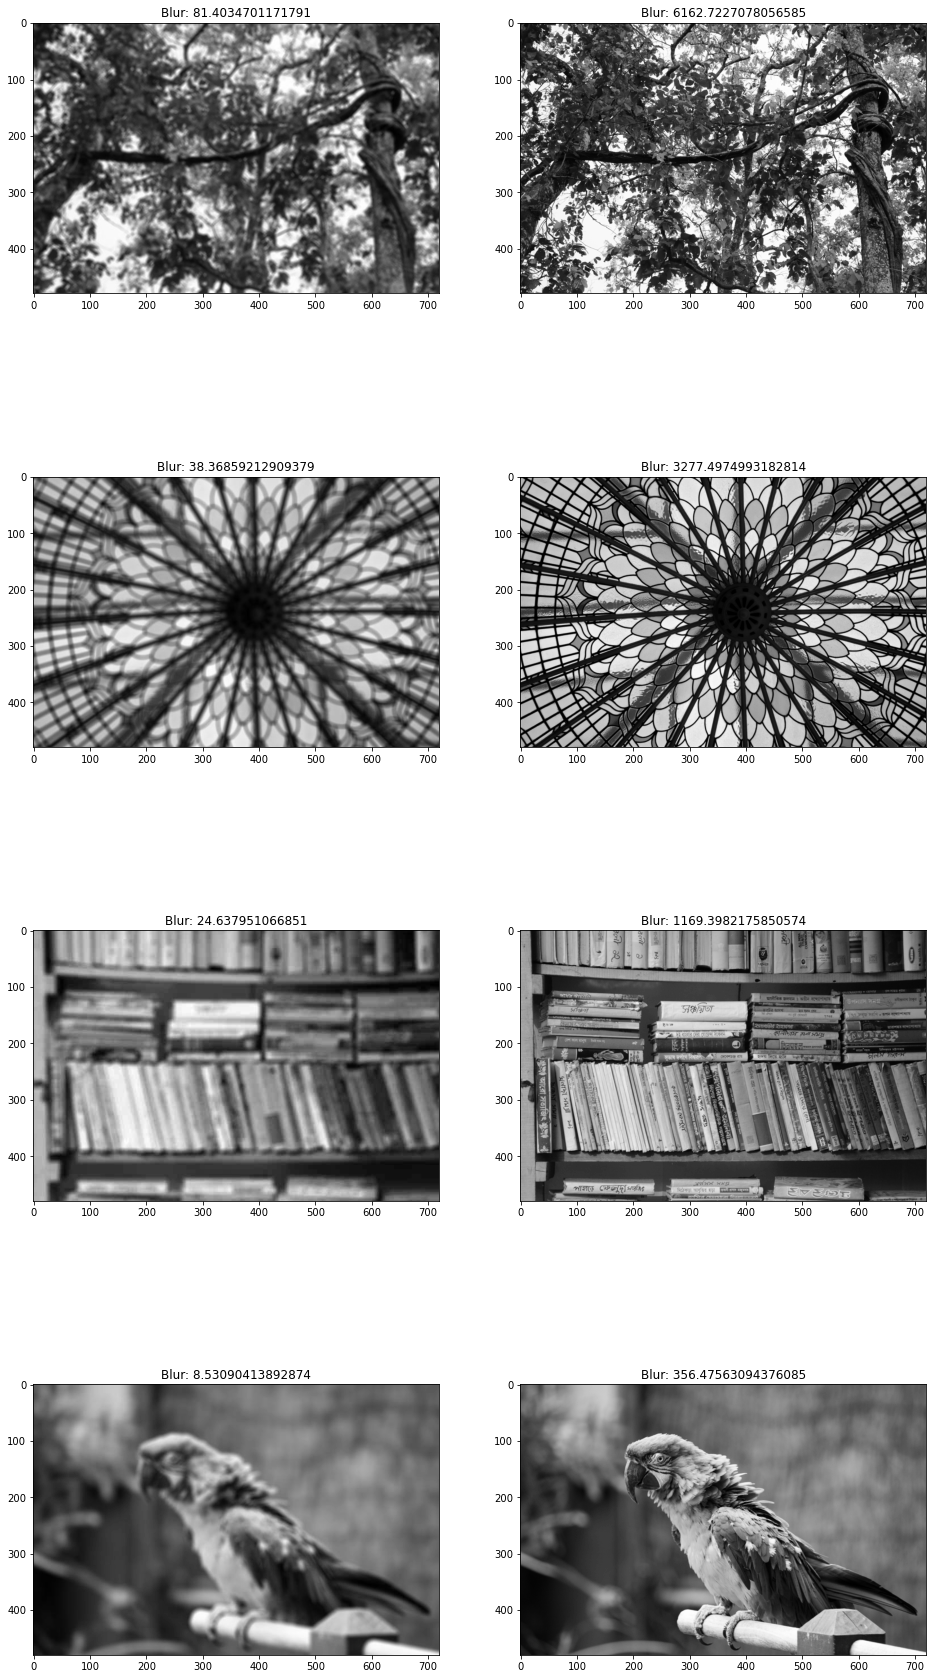

In [19]:
show_batch(valid_data_loader,size =8)

# VDSR

In [20]:
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from functools import partial

class Conv_ReLU_Block(nn.Module):
    def __init__(self,channels=64):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))

class VDSRNet(nn.Module):
    def __init__(self, image_channels=3, blocks=18, feature_channels=64):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(partial(Conv_ReLU_Block,channels=feature_channels), blocks)
        self.input = nn.Conv2d(in_channels=image_channels, out_channels=feature_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=feature_channels, out_channels=image_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    def forward8(self, x):
        #residual = x
        out = self.relu(self.input(x.float()))
        out = self.residual_layer(out)
        out = self.output(out).int8()
        out = torch.add(out,x).clamp(0,255)
        return out

# build the model

In [21]:
model = VDSRNet(image_channels=1, blocks=18, feature_channels=64)
model.cuda()

VDSRNet(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (6): Conv_ReL

In [22]:
num_pixels = crop_size[0] * crop_size[1]

In [23]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [24]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.L1Loss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [25]:
criterion = Pixel_Loss(num_pixels)
#criterion = nn.L1Loss(reduction = 'mean')
#criterionk = nn.MSELoss(reduction = 'mean')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [26]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 27

loops = 4

In [27]:

optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=0)



In [28]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [29]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [30]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [31]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [32]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [33]:
def trainfp16(training_data_loader, optimizer, scheduler, model,   epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    ct=0  ##need to use a different variable.
    ct2=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for loop_count in range(loops):  
        for iteration, batch in enumerate(training_data_loader, 1):
            inpt, target, camera_specs = batch[0], batch[1], batch[2]


            inpt = inpt.cuda()

            target = target.cuda()
            
            
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(inpt)
                loss = criterion(output, target)


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            scaler.unscale_(optimizer)

            nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss = cum_loss + loss.data


            ct = ct +1 



            pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss/ct)        

In [34]:
def validatefp16(valid_data_loader, model,   loop=10):

    model.eval()
    cum_loss2=0
    cum_loss1 = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                inpt, target, camera_specs = batch[0], batch[1], batch[2]


                inpt = inpt.cuda()

                target = target.cuda()
                
                
                
                # Runs the forward pass with autocasting.
                with autocast():
                    output = model(inpt)
                    loss1 = criterion(output, target)
                

                #print(k_pred[:,0].shape, k_target.shape)
               
                cum_loss1 = cum_loss1 + loss1.data
                

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation Loss: {:.10f} ".format(cum_loss1/ct) )
    
    return (cum_loss1/ct).item()

In [35]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN3_epoch_54.pth")["model"]

In [36]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [37]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/800 [00:00<?, ?it/s]

Start Time: 2020-11-12 20:28:08.864465
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.9160, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 7.7460937500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_1.pth
Start Time: 2020-11-12 20:45:35.359627
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3984, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.3320312500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_2.pth
Start Time: 2020-11-12 21:02:46.536127
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.4434, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9882812500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_3.pth
Start Time: 2020-11-12 21:19:49.814683
Epoch = 4, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3340, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0664062500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_4.pth
Start Time: 2020-11-12 21:36:52.073134
Epoch = 5, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3359, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9277343750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_5.pth
Start Time: 2020-11-12 21:53:53.248634
Epoch = 6, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3457, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9023437500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_6.pth
Start Time: 2020-11-12 22:10:57.203542
Epoch = 7, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3652, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.8828125000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_7.pth
Start Time: 2020-11-12 22:28:00.739683
Epoch = 8, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3477, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0644531250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_8.pth
Start Time: 2020-11-12 22:45:03.057913
Epoch = 9, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.2910, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9687500000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_9.pth
Start Time: 2020-11-12 23:02:04.451814
Epoch = 10, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3223, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9863281250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_10.pth
Start Time: 2020-11-12 23:19:02.659133
Epoch = 11, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.2852, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9589843750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_11.pth
Start Time: 2020-11-12 23:36:04.055183
Epoch = 12, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3613, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0449218750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_12.pth
Start Time: 2020-11-12 23:53:05.539288
Epoch = 13, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3613, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0253906250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_13.pth
Start Time: 2020-11-13 00:10:10.668984
Epoch = 14, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3613, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9414062500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_14.pth
Start Time: 2020-11-13 00:27:11.753756
Epoch = 15, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3125, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0058593750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_15.pth
Start Time: 2020-11-13 00:44:12.273977
Epoch = 16, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3730, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0156250000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_16.pth
Start Time: 2020-11-13 01:01:13.534522
Epoch = 17, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3516, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9980468750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_17.pth
Start Time: 2020-11-13 01:18:14.468965
Epoch = 18, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3379, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0683593750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_18.pth
Start Time: 2020-11-13 01:35:18.312868
Epoch = 19, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3477, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0273437500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_19.pth
Start Time: 2020-11-13 01:52:21.624505
Epoch = 20, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3906, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0644531250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_20.pth
Start Time: 2020-11-13 02:09:24.954107
Epoch = 21, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3516, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0078125000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_21.pth
Start Time: 2020-11-13 02:26:28.204186
Epoch = 22, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.2910, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9589843750 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_22.pth
Start Time: 2020-11-13 02:43:31.795058
Epoch = 23, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3633, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0253906250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_23.pth
Start Time: 2020-11-13 03:00:33.955334
Epoch = 24, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3750, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 2.9804687500 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_24.pth
Start Time: 2020-11-13 03:17:37.012158
Epoch = 25, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3125, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0234375000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_25.pth
Start Time: 2020-11-13 03:34:44.301647
Epoch = 26, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3457, device='cuda:0', dtype=torch.float16)


  0%|          | 0/800 [00:00<?, ?it/s]

===> Epoch Validation Loss: 3.0312500000 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_26.pth
Start Time: 2020-11-13 03:51:55.672095
Epoch = 27, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(3.3203, device='cuda:0', dtype=torch.float16)


100%|██████████| 10/10 [02:05<00:00, 12.56s/it]

===> Epoch Validation Loss: 3.0488281250 
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW5_epoch_27.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth")["model"]

In [ ]:
def sb(batin,batout, size=8):

    
    outputs = batout.numpy().transpose((0, 2, 3, 1))
    inputs = batin.numpy().transpose((0, 2, 3, 1))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    
    outputs = (outputs*255.0).clip(0,255)
    inputs = (inputs*255.0).clip(0,255)
    
    fig=plt.figure(figsize=(2*size, 4*size))
    rows = outputs.shape[0]
    columns = 2
    ax=[]
    for i in range(0, rows):
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        plt.imshow((inputs[i]).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        plt.imshow((outputs[i]).astype(np.uint8),cmap='gray')
    plt.show()
    
   
    
   

In [ ]:
class Combine_Nets(nn.Module):
    def __init__(self, model, kmodel):
        super(Combine_Nets, self).__init__()   
        
        
        self.model = model
        self.kmodel = kmodel
        
        

    def forward(self, x):    
        
       
        k = self.kmodel(x)
        x = self.model(x,k)
        
        return x,k

In [ ]:
mcombine = Combine_Nets(model,kmodel)

In [ ]:
inputs, outputs, camera_specs = next(iter(training_data_loader))

In [ ]:
inputs = inputs.cuda()

            
with torch.no_grad():
    with autocast():
        out = mcombine(inputs)

In [ ]:
sb(inputs.cpu(),out[0].cpu())

In [ ]:
out[1]

In [ ]:
def cv2_to_batch_tensor(img_bgr):
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = im_rgb/255.0
    im_rgb = (im_rgb-mn)/std
    tform = im_rgb.transpose(( 2,0, 1))
    tform = torch.from_numpy(tform).float()
    tform = tform.unsqueeze(0)
    return tform

In [ ]:
def batch_tensor_to_cv2(bt_3ch):
    bt_3ch = (bt_3ch*255.0).clamp(0,255)
    t_3ch = bt_3ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_rbg = t_3ch.permute(1,2,0).numpy().astype(np.uint8)
    im_bgr = cv2.cvtColor(im_rbg, cv2.COLOR_RGB2BGR)
    
    return im_bgr

In [ ]:
# test
img_cv = cv2.imread("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png")

t = cv2_to_batch_tensor(img_bgr=img_cv)
print(t.shape)
img_cv2 = batch_tensor_to_cv2(bt_3ch=t)



In [ ]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))

In [ ]:
#test2
#t = torch.rand(1,3,1,1)
inputs, outputs, camera_specs = next(iter(training_data_loader))

t=outputs[0].unsqueeze(0)
img_cv = batch_tensor_to_cv2(bt_3ch=t)
t2 = cv2_to_batch_tensor(img_bgr=img_cv)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

In [ ]:
img = Image.open("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png").convert("RGB")

In [ ]:
img = cv2.imread("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png")
    # convert to PIL RGB
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Image.fromarray(im_rgb)
im_input = im_rgb/255.0

In [ ]:
#im_input = np.array(img)/255.0
im_input.shape

In [ ]:
mn=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
im_input = (im_input-mn)/std

In [ ]:
tform = im_input.transpose(( 2,0, 1))
tform.shape

In [ ]:
tform = torch.from_numpy(tform).float()
tform.shape

In [ ]:
inputs = tform.unsqueeze(0)
inputs.shape

In [ ]:
#test
img_cv = cv2.imread("/media/SSD/superres/Screenshot from snip.mp4.png")
inputs = cv2_to_batch_tensor(img_bgr=img_cv)
inputs = inputs.cuda()

            
with torch.no_grad():
    with autocast():
        out = mcombine(inputs)
im_out = batch_tensor_to_cv2(out[0].cpu())
plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))

In [ ]:
sb(inputs.cpu(),out[0].cpu())

In [ ]:
import math
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [ ]:
from superres_utils import PSNR, decolorize, variance_of_laplacian, is_image_file

def display_PSNR(im_gt, im_b, im_in, model, channels=1, display=True, k_scale = 1.0):
    
    model.eval()
    
    #mn=np.array([0.485, 0.456, 0.406])
    #std=np.array([0.229, 0.224, 0.225])
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = cv2_to_batch_tensor(img_bgr=np.array(im_in))
        
    print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with torch.no_grad():
        with autocast():
            mout = model(im_input)
    
    #sb(im_input.cpu(),mout[0].cpu())
    
    if len(mout)>1:
        out = mout[0]
        k=mout[1].item()*k_scale
    else:
        out = mout
        k=None
        
        
    
    
    if channels == 1:
        out = (out*255.0).clamp(0,255)
    
        out = out.cpu()
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out=",out.shape)
        #print("out.data=",out.data.shape)
        #print("im_input.shape=",im_input.shape)
        #im_h = out[0].data.view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        im_h = batch_tensor_to_cv2(out.cpu())
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        print("Estimate of kernel:", k)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    
    
    return k, psnr_predicted , blur_measure_input

In [38]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


In [ ]:
im_b = Image.open("/home/filip/Pictures/Screenshot from super8_best_from_mp2.mp4.png").convert("RGB")

display_PSNR(im_b, im_b, im_b, mcombine, channels=3)

im_input.shape= torch.Size([1, 1, 256, 256])
psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 29.089368857345768dB
PSNR improvement is 0.5876875551278253dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 100.02612277772278
Estimate of kernel: None


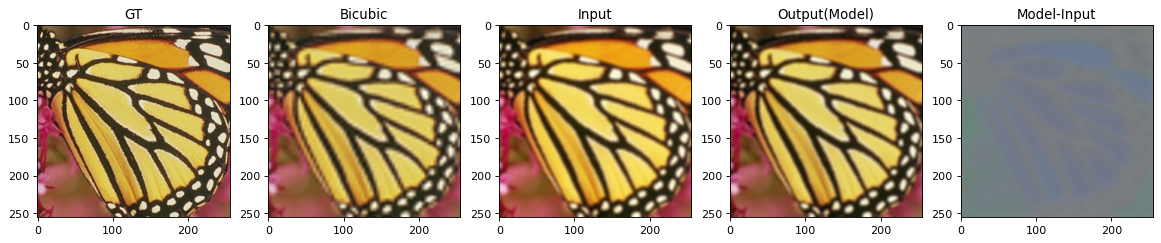

(None, 29.089368857345768, 97.89891300513409)

In [39]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1)


In [ ]:
from jupyterplot import ProgressPlot


In [ ]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [ ]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,50]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), mcombine, channels=3, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), mcombine, channels=3, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

In [ ]:
from superres_utils import is_image_file
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, model, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(2*height/scale), int(2*width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = pil_disk_blur(im_gt,scale)
            
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 


In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 10, mcombine, channels = 3,display = True)

# convert sample videos

In [ ]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 1, center_crop = None):
    
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)
                
                

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = cv2_to_batch_tensor(frame)
        
  
                im_input = im_input.cuda()
    
                
                
                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)  
                
                if len(mout) >1:
                    out=mout[0].cpu()
                    
                else:
                    out = mout.cpu()
                    
                
                im_h = batch_tensor_to_cv2(out)
                

            #Add notation and crude bar chart to video frame
            
            if len(mout)>1:
                cv2.putText(im_h, text='k={:.2f}'.format(k_scale*mout[1].item()), org=(new_width-70,new_height-50),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=1, lineType=cv2.LINE_AA)
                
                cv2.putText(im_h, text='_', org=(new_width-5,new_height - int(new_height*mout[1].item()/17)),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=2, lineType=cv2.LINE_AA)
                
                
            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
result_path

In [ ]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, mcombine,channels=3, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, mcombine,channels=3, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, mcombine,channels=3, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8longcrop.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",
             errorfile = error_file, center_crop = (680,450))

In [ ]:
dualfile= str(result_path/"super8longcropdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}